In [ ]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Fix max mel size issue by padding all to the same length
def pad_mel_spectrogram(mel_spectrogram, max_length):
    pad_size = max_length - mel_spectrogram.shape[1]
    return torch.nn.functional.pad(mel_spectrogram, (0, pad_size))

class LJSpeechDataset(Dataset):
    def __init__(self, dataset_path="LJSpeech-1.1", num_samples=100):
        metadata_path = os.path.join(dataset_path, "metadata.csv")
        audio_path = os.path.join(dataset_path, "wavs")

        with open(metadata_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        self.samples = []
        self.max_mel_length = 0  # Track max length to pad later
        
        for line in lines[:num_samples]:  # Limit number of samples
            parts = line.strip().split("|")
            audio_file = os.path.join(audio_path, parts[0] + ".wav")
            text = parts[1]

            # Convert audio to Mel spectrogram
            waveform, sr = torchaudio.load(audio_file)
            mel_spectrogram = torchaudio.transforms.MelSpectrogram(n_mels=80)(waveform)
            mel_spectrogram = torch.mean(mel_spectrogram, dim=0)  # Convert stereo to mono if needed

            # Normalize the Mel spectrogram
            mel_spectrogram = mel_spectrogram / mel_spectrogram.max()

            self.max_mel_length = max(self.max_mel_length, mel_spectrogram.shape[1])

            # Convert text to embeddings (placeholder)
            text_embedding = torch.randn(400)

            self.samples.append((text_embedding, mel_spectrogram, mel_spectrogram.shape[1]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text_embedding, mel_spectrogram, mel_length = self.samples[idx]
        mel_spectrogram = pad_mel_spectrogram(mel_spectrogram, self.max_mel_length)  # Fix shape mismatch
        return text_embedding, mel_spectrogram, mel_length

In [25]:
def masked_mse_loss(pred, target, lengths):
    """
    Computes Mean Squared Error loss while ignoring padding.
    Args:
        pred: (batch_size, max_frames, 80) - Model output
        target: (batch_size, max_frames, 80) - Ground truth
        lengths: (batch_size,) - Number of valid frames per sample
    """
    mask = torch.arange(target.shape[1]).unsqueeze(0) < lengths.unsqueeze(1)  # Shape (batch_size, max_frames)
    mask = mask.unsqueeze(-1).to(target.device)  # Shape (batch_size, max_frames, 1)
    
    loss = (pred - target) ** 2
    loss = loss * mask  # Zero out loss for padded frames
    return loss.sum() / mask.sum()  # Average over valid frames


# Create a simple model (Tacotron2 Placeholder)
class Tacotron2Placeholder(nn.Module):
    def __init__(self, input_dim=400, hidden_dim=1024, output_dim=80):
        super(Tacotron2Placeholder, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, max_frames):
        hidden = self.relu(self.hidden_layer(x))
        output = self.output_layer(hidden)
        output = output.view(x.size(0), max_frames, -1)  # Reshape to (batch_size, max_frames, output_dim)
        return output

In [ ]:
# Function to select optimizer
def get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=0.9):
    if optimizer_type == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_type == 'lbfgs':
        return optim.LBFGS(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

def check_for_nans(tensor):
    if torch.isnan(tensor).any():
        raise ValueError("NaN values found in the input data")

# Function to train the model for one epoch
def train_one_epoch(epoch, model, criterion, optimizer, dataloader, device, scaler, amp, optimizer_type):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        text_input, mel_target, mel_lengths = batch
        check_for_nans(text_input)
        check_for_nans(mel_target)
        check_for_nans(mel_lengths)
        text_input, mel_target, mel_lengths = text_input.to(device), mel_target.to(device), mel_lengths.to(device)

        def closure():
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=amp):
                mel_predicted = model(text_input, mel_target.size(1))
                loss = criterion(mel_predicted, mel_target, mel_lengths)
            loss.backward()
            return loss
        
        if optimizer_type == 'lbfgs':
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=amp):
                mel_predicted = model(text_input, mel_target.size(1))
                loss = criterion(mel_predicted, mel_target, mel_lengths)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()

        epoch_loss += loss.item()
    
    average_loss = epoch_loss / len(dataloader)
    return average_loss
# Function to validate the model
def validate(model, criterion, dataloader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            text_input, mel_target, mel_lengths = batch
            text_input, mel_target, mel_lengths = text_input.to(device), mel_target.to(device), mel_lengths.to(device)
            mel_predicted = model(text_input, mel_target.size(1))
            loss = criterion(mel_predicted, mel_target, mel_lengths)
            val_loss += loss.item()
    average_val_loss = val_loss / len(dataloader)
    return average_val_loss

In [32]:
# Load dataset
dataset_path = "LJSpeech-1.1"
num_samples = 100  # You can adjust this number for a larger dataset
batch_size = 8
learning_rate = 0.0001  # Reduced learning rate
epochs = 10

# Instantiate dataset and dataloaders
train_dataset = LJSpeechDataset(dataset_path=dataset_path, num_samples=num_samples)
val_dataset = LJSpeechDataset(dataset_path=dataset_path, num_samples=20)  # Use a smaller validation set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cpu")
model = Tacotron2Placeholder().to(device)
criterion = masked_mse_loss

# Optimizers to test
optimizers = ['sgd']
all_losses = {}

for opt in optimizers:
    print(f"Training with {opt} optimizer")
    optimizer = get_optimizer(model, optimizer_type=opt, lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler(enabled=False)  # Disable AMP for CPU

    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        train_loss = train_one_epoch(epoch, model, criterion, optimizer, train_loader, device, scaler, False, opt)
        val_loss = validate(model, criterion, val_loader, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    all_losses[opt] = (train_losses, val_losses)

Training with sgd optimizer
Epoch 1/10, Train Loss: 449685.2692, Val Loss: 1046923.2917
Epoch 2/10, Train Loss: nan, Val Loss: nan
Epoch 3/10, Train Loss: nan, Val Loss: nan
Epoch 4/10, Train Loss: nan, Val Loss: nan
Epoch 5/10, Train Loss: nan, Val Loss: nan
Epoch 6/10, Train Loss: nan, Val Loss: nan
Epoch 7/10, Train Loss: nan, Val Loss: nan
Epoch 8/10, Train Loss: nan, Val Loss: nan
Epoch 9/10, Train Loss: nan, Val Loss: nan
Epoch 10/10, Train Loss: nan, Val Loss: nan


In [ ]:
import torch.nn.functional as F

def compute_mcd(pred, target, lengths):
    """
    Computes Mel Cepstral Distortion (MCD) between predicted and target Mel spectrograms.
    Args:
        pred: (batch_size, max_frames, 80) - Model output
        target: (batch_size, max_frames, 80) - Ground truth
        lengths: (batch_size,) - Number of valid frames per sample
    Returns:
        mcd: Mel Cepstral Distortion
    """
    # Apply mask to ignore padding
    mask = torch.arange(target.shape[1]).unsqueeze(0) < lengths.unsqueeze(1)
    mask = mask.unsqueeze(-1).to(target.device)
    pred = pred * mask
    target = target * mask

    # Compute log Mel spectrograms with epsilon to avoid log(0)
    epsilon = 1e-10
    pred_log = torch.log(pred + epsilon)
    target_log = torch.log(target + epsilon)

    # Compute the MCD
    diff = pred_log - target_log
    squared_diff = diff ** 2
    sum_squared_diff = torch.sum(squared_diff, dim=-1)
    mcd = 10.0 / torch.log(torch.tensor(10.0)) * torch.sqrt(2.0 * sum_squared_diff)
    
    # Check for NaNs/Infs
    if torch.isnan(mcd).any() or torch.isinf(mcd).any():
        raise ValueError("NaN or Inf values found in MCD computation")

    # Average over valid frames
    mcd = torch.sum(mcd * mask.squeeze(-1)) / torch.sum(mask)
    return mcd.item()


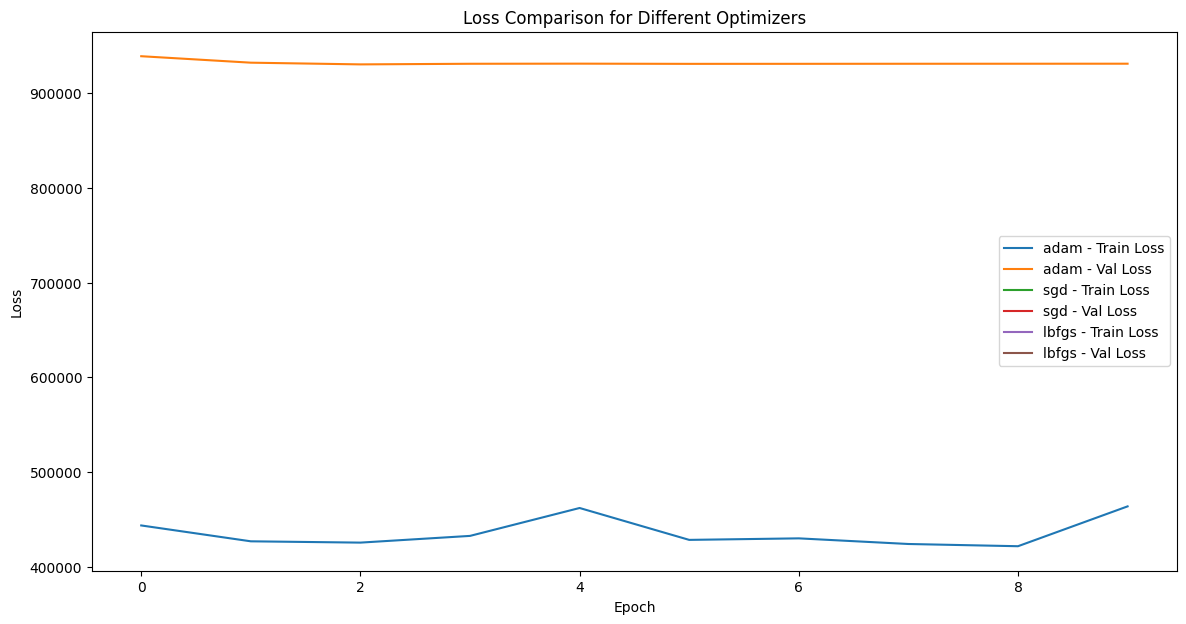

In [ ]:
# Plot the losses for comparison
plt.figure(figsize=(14, 7))

for opt in optimizers:
    train_losses, val_losses = all_losses[opt]
    plt.plot(train_losses, label=f'{opt} - Train Loss')
    plt.plot(val_losses, label=f'{opt} - Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison for Different Optimizers')
plt.legend()
plt.show()

Training with adam optimizer
Epoch 1, Optimizer adam, Train Loss: 30.091598510742188
Validation Loss: 30.129722595214844, Validation MCD: 2450.315185546875
Epoch 1/100, Train Loss: 30.0916, Val Loss: 30.1297, Val MCD: 2450.3152
Epoch 2, Optimizer adam, Train Loss: 29.429746627807617
Validation Loss: 29.63835906982422, Validation MCD: 2444.210205078125
Epoch 2/100, Train Loss: 29.4297, Val Loss: 29.6384, Val MCD: 2444.2102
Epoch 3, Optimizer adam, Train Loss: 28.777862548828125
Validation Loss: 29.153419494628906, Validation MCD: 2438.34521484375
Epoch 3/100, Train Loss: 28.7779, Val Loss: 29.1534, Val MCD: 2438.3452
Epoch 4, Optimizer adam, Train Loss: 28.13585662841797
Validation Loss: 28.67487335205078, Validation MCD: 2433.063232421875
Epoch 4/100, Train Loss: 28.1359, Val Loss: 28.6749, Val MCD: 2433.0632
Epoch 5, Optimizer adam, Train Loss: 27.503704071044922
Validation Loss: 28.202722549438477, Validation MCD: 2426.360107421875
Epoch 5/100, Train Loss: 27.5037, Val Loss: 28.2027,

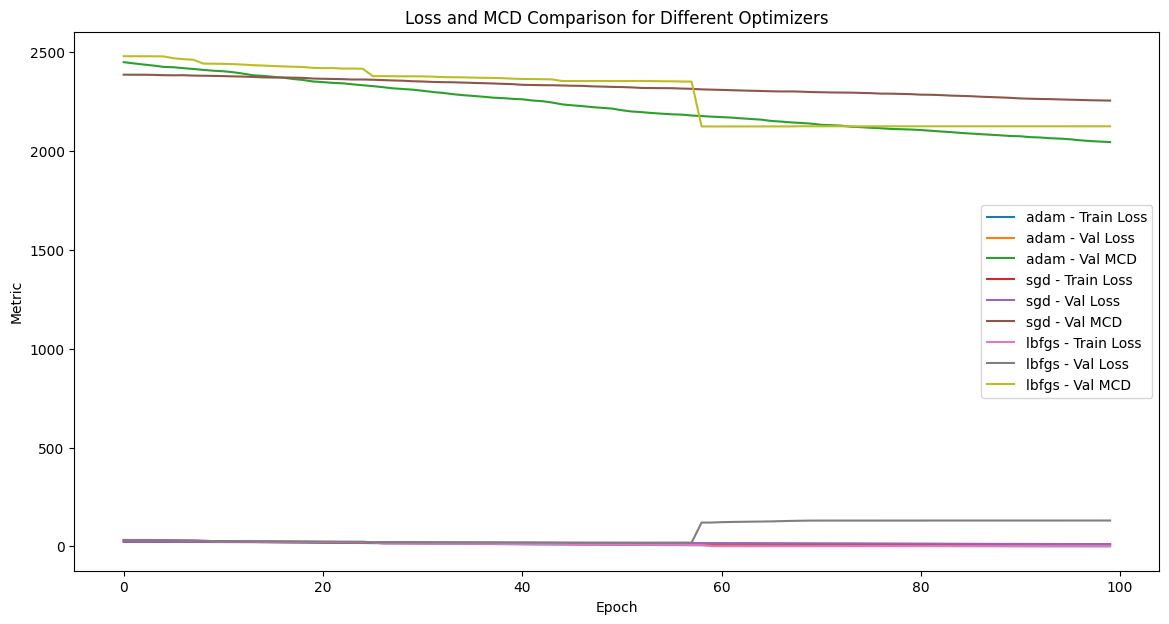

In [3]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


def pad_mel_spectrogram(mel_spectrogram, max_length):
    pad_size = max_length - mel_spectrogram.shape[1]
    return torch.nn.functional.pad(mel_spectrogram, (0, pad_size))

class LJSpeechDataset(Dataset):
    def __init__(self, dataset_path="LJSpeech-1.1", num_samples=100):
        metadata_path = os.path.join(dataset_path, "metadata.csv")
        audio_path = os.path.join(dataset_path, "wavs")

        with open(metadata_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        self.samples = []
        self.max_mel_length = 0
        
        for line in lines[:num_samples]:
            parts = line.strip().split("|")
            audio_file = os.path.join(audio_path, parts[0] + ".wav")
            text = parts[1]

            waveform, sr = torchaudio.load(audio_file)
            mel_spectrogram = torchaudio.transforms.MelSpectrogram(n_mels=80)(waveform)
            mel_spectrogram = torch.mean(mel_spectrogram, dim=0)

            mel_spectrogram = mel_spectrogram / (mel_spectrogram.max() + 1e-10)  # Avoid division by zero

            self.max_mel_length = max(self.max_mel_length, mel_spectrogram.shape[1])

            text_embedding = torch.randn(400)

            self.samples.append((text_embedding, mel_spectrogram, mel_spectrogram.shape[1]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text_embedding, mel_spectrogram, mel_length = self.samples[idx]
        mel_spectrogram = pad_mel_spectrogram(mel_spectrogram, self.max_mel_length)
        return text_embedding, mel_spectrogram, mel_length

def masked_mse_loss(pred, target, lengths):
    mask = torch.arange(target.shape[1]).unsqueeze(0) < lengths.unsqueeze(1)
    mask = mask.unsqueeze(-1).to(target.device)
    
    loss = (pred - target) ** 2
    loss = loss * mask
    return loss.sum() / mask.sum()

class Tacotron2Placeholder(nn.Module):
    def __init__(self, input_dim=400, hidden_dim=1024, output_dim=80):
        super(Tacotron2Placeholder, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.output_activation = nn.ReLU()  # Ensure non-negative outputs
        self._initialize_weights()

    def forward(self, x, max_frames):
        hidden = self.relu(self.hidden_layer(x))
        output = self.output_layer(hidden)
        output = self.output_activation(output)  # Apply ReLU activation
        output = output.view(x.size(0), max_frames, -1)
        return output

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def reinitialize_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def get_optimizer(model, optimizer_type='adam', lr=0.000001, momentum=0.9):
    if optimizer_type == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'sgd':
        return optim.SGD(model.parameters(), lr=0.0001, momentum=momentum)  # Increased learning rate
    elif optimizer_type == 'lbfgs':
        return optim.LBFGS(model.parameters(), lr=0.00001)  # Increased learning rate
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

def check_for_nans(tensor, name=""):
    if torch.isnan(tensor).any():
        raise ValueError(f"NaN values found in {name}")
    if torch.isinf(tensor).any():
        raise ValueError(f"Inf values found in {name}")

def compute_mcd(pred, target, lengths):
    mask = torch.arange(target.shape[1]).unsqueeze(0) < lengths.unsqueeze(1)
    mask = mask.unsqueeze(-1).to(target.device)
    pred = pred * mask
    target = target * mask

    epsilon = 1e-10
    pred_log = torch.log(pred + epsilon)
    target_log = torch.log(target + epsilon)

    # Check for NaNs/Infs in log transformation
    if torch.isnan(pred_log).any() or torch.isinf(pred_log).any():
        print("NaN or Inf values found in pred_log")
    if torch.isnan(target_log).any() or torch.isinf(target_log).any():
        print("NaN or Inf values found in target_log")

    diff = pred_log - target_log
    squared_diff = diff ** 2
    sum_squared_diff = torch.sum(squared_diff, dim=-1)
    mcd = 10.0 / torch.log(torch.tensor(10.0)) * torch.sqrt(2.0 * sum_squared_diff)
    
    # Check for NaNs/Infs in MCD computation
    if torch.isnan(mcd).any() or torch.isinf(mcd).any():
        print(f"pred_log: {pred_log}")
        print(f"target_log: {target_log}")
        print(f"diff: {diff}")
        print(f"squared_diff: {squared_diff}")
        print(f"sum_squared_diff: {sum_squared_diff}")
        raise ValueError("NaN or Inf values found in MCD computation")

    mcd = torch.sum(mcd * mask.squeeze(-1)) / torch.sum(mask)
    return mcd.item()

def train_one_epoch(epoch, model, criterion, optimizer, dataloader, device, scaler, amp, optimizer_type):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        text_input, mel_target, mel_lengths = batch
        check_for_nans(text_input, "text_input")
        check_for_nans(mel_target, "mel_target")
        check_for_nans(mel_lengths, "mel_lengths")
        text_input, mel_target, mel_lengths = text_input.to(device), mel_target.to(device), mel_lengths.to(device)

        def closure():
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=amp):
                mel_predicted = model(text_input, mel_target.size(1))
                check_for_nans(mel_predicted, "mel_predicted")
                loss = criterion(mel_predicted, mel_target, mel_lengths)
                check_for_nans(loss, "loss")
            loss.backward()
            return loss
        
        if optimizer_type == 'lbfgs':
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=amp):
                mel_predicted = model(text_input, mel_target.size(1))
                check_for_nans(mel_predicted, "mel_predicted")
                loss = criterion(mel_predicted, mel_target, mel_lengths)
                check_for_nans(loss, "loss")
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

        epoch_loss += loss.item()
    
    average_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch + 1}, Optimizer {optimizer_type}, Train Loss: {average_loss}")
    return average_loss

def validate(model, criterion, dataloader, device):
    model.eval()
    val_loss = 0
    val_mcd = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            text_input, mel_target, mel_lengths = batch
            check_for_nans(text_input, "text_input")
            check_for_nans(mel_target, "mel_target")
            check_for_nans(mel_lengths, "mel_lengths")
            text_input, mel_target, mel_lengths = text_input.to(device), mel_target.to(device), mel_lengths.to(device)
            mel_predicted = model(text_input, mel_target.size(1))
            check_for_nans(mel_predicted, "mel_predicted")
            loss = criterion(mel_predicted, mel_target, mel_lengths)
            check_for_nans(loss, "loss")
            val_loss += loss.item()
            
            mcd = compute_mcd(mel_predicted, mel_target, mel_lengths)
            val_mcd += mcd
    average_val_loss = val_loss / len(dataloader)
    average_val_mcd = val_mcd / len(dataloader)
    print(f"Validation Loss: {average_val_loss}, Validation MCD: {average_val_mcd}")
    return average_val_loss, average_val_mcd

dataset_path = "LJSpeech-1.1"
num_samples = 100
batch_size = 10000
learning_rate = 0.00001
epochs = 100

train_dataset = LJSpeechDataset(dataset_path=dataset_path, num_samples=num_samples)
val_dataset = LJSpeechDataset(dataset_path=dataset_path, num_samples=20)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cpu")
criterion = masked_mse_loss

optimizers = ['adam', 'sgd', 'lbfgs']
all_losses = {}

for opt in optimizers:
    print(f"Training with {opt} optimizer")
    model = Tacotron2Placeholder().to(device)
    reinitialize_model(model)  # Reinitialize model weights
    optimizer = get_optimizer(model, optimizer_type=opt, lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler(enabled=False)

    train_losses = []
    val_losses = []
    val_mcds = []
    
    for epoch in range(epochs):
        train_loss = train_one_epoch(epoch, model, criterion, optimizer, train_loader, device, scaler, False, opt)
        val_loss, val_mcd = validate(model, criterion, val_loader, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_mcds.append(val_mcd)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MCD: {val_mcd:.4f}")
    
    all_losses[opt] = (train_losses, val_losses, val_mcds)

# Plot the losses and MCD for comparison
plt.figure(figsize=(14, 7))

for opt in optimizers:
    train_losses, val_losses, val_mcds = all_losses[opt]
    plt.plot(train_losses, label=f'{opt} - Train Loss')
    plt.plot(val_losses, label=f'{opt} - Val Loss')
    plt.plot(val_mcds, label=f'{opt} - Val MCD')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Loss and MCD Comparison for Different Optimizers')
plt.legend()
plt.show()

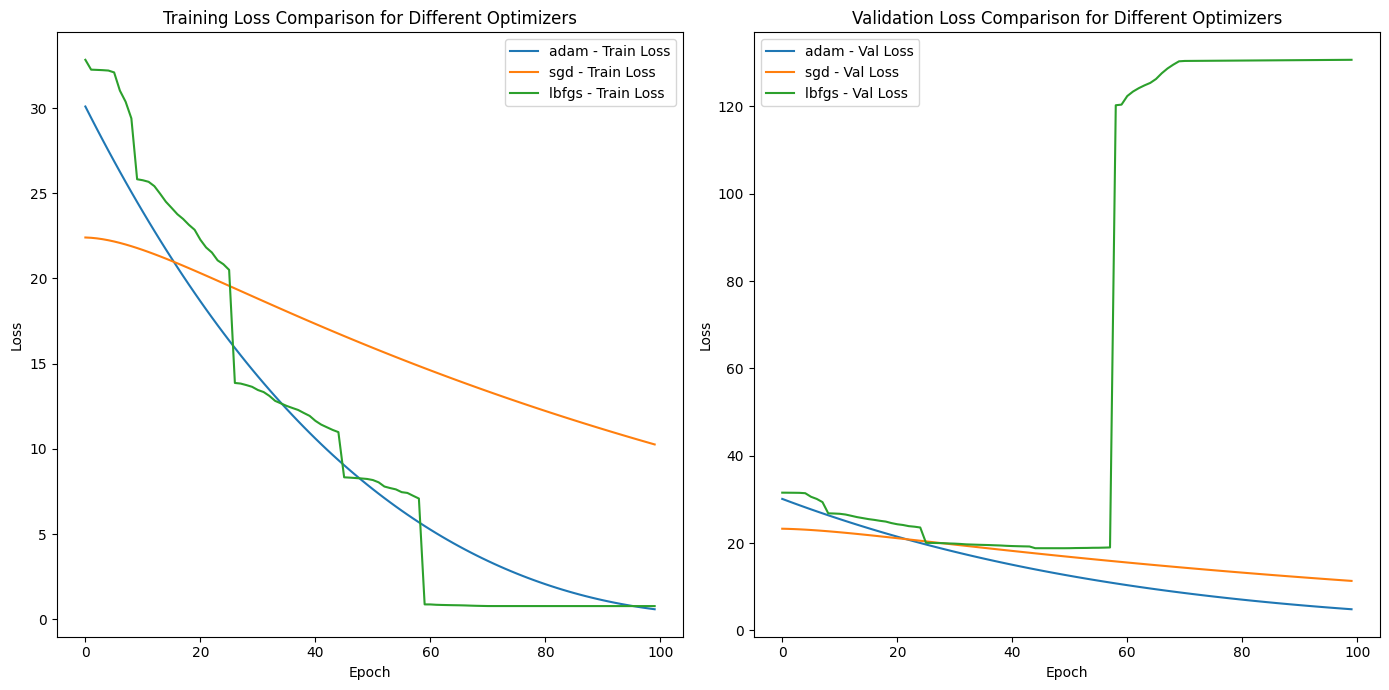

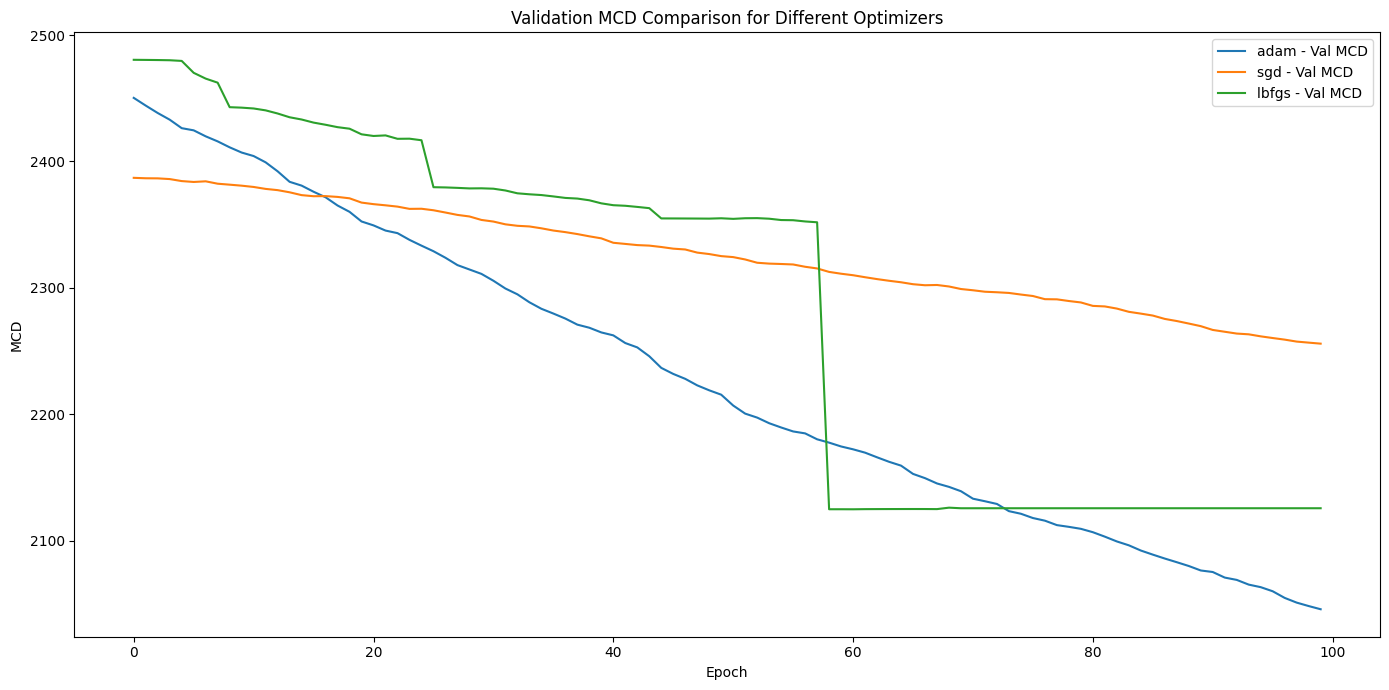

In [4]:
import matplotlib.pyplot as plt

# Function to plot training and validation statistics
def plot_statistics(all_losses, metric_name='Loss'):
    plt.figure(figsize=(14, 7))
    
    for opt in all_losses:
        train_losses, val_losses, val_mcds = all_losses[opt]
        
        # Plot training loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label=f'{opt} - Train {metric_name}')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.title(f'Training {metric_name} Comparison for Different Optimizers')
        plt.legend()
        
        # Plot validation loss or MCD
        plt.subplot(1, 2, 2)
        plt.plot(val_losses, label=f'{opt} - Val {metric_name}')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.title(f'Validation {metric_name} Comparison for Different Optimizers')
        plt.legend()
        
    plt.tight_layout()
    plt.show()

# Plot training and validation losses
plot_statistics(all_losses, metric_name='Loss')

# Function to plot validation MCD
def plot_mcd(all_losses):
    plt.figure(figsize=(14, 7))
    
    for opt in all_losses:
        _, _, val_mcds = all_losses[opt]
        
        # Plot validation MCD
        plt.plot(val_mcds, label=f'{opt} - Val MCD')
        plt.xlabel('Epoch')
        plt.ylabel('MCD')
        plt.title('Validation MCD Comparison for Different Optimizers')
        plt.legend()
        
    plt.tight_layout()
    plt.show()

# Plot validation MCD
plot_mcd(all_losses)

Training with adam optimizer
Epoch 1, Optimizer adam, Train Loss: 20.743232454572404
Validation Loss: 9.398500919342041, Validation MCD: 2145.22900390625
Epoch 1/10, Train Loss: 20.7432, Val Loss: 9.3985, Val MCD: 2145.2290
Epoch 2, Optimizer adam, Train Loss: 4.430475916181292
Validation Loss: 2.958212375640869, Validation MCD: 1962.9197998046875
Epoch 2/10, Train Loss: 4.4305, Val Loss: 2.9582, Val MCD: 1962.9198
Epoch 3, Optimizer adam, Train Loss: 0.6201838893549783
Validation Loss: 1.0911536812782288, Validation MCD: 1882.9636840820312
Epoch 3/10, Train Loss: 0.6202, Val Loss: 1.0912, Val MCD: 1882.9637
Epoch 4, Optimizer adam, Train Loss: 0.283930133496012
Validation Loss: 0.6328858435153961, Validation MCD: 1848.0882568359375
Epoch 4/10, Train Loss: 0.2839, Val Loss: 0.6329, Val MCD: 1848.0883
Epoch 5, Optimizer adam, Train Loss: 0.27728162705898285
Validation Loss: 0.49793657660484314, Validation MCD: 1842.7898559570312
Epoch 5/10, Train Loss: 0.2773, Val Loss: 0.4979, Val MCD:

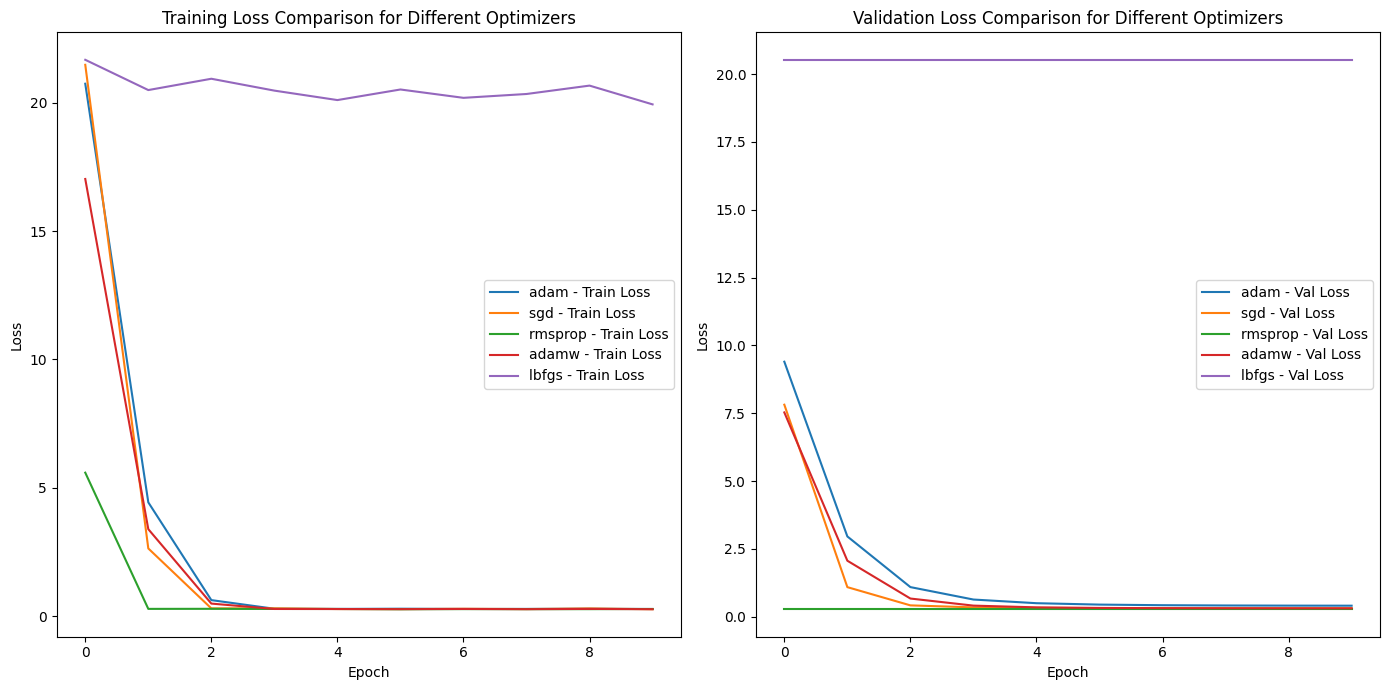

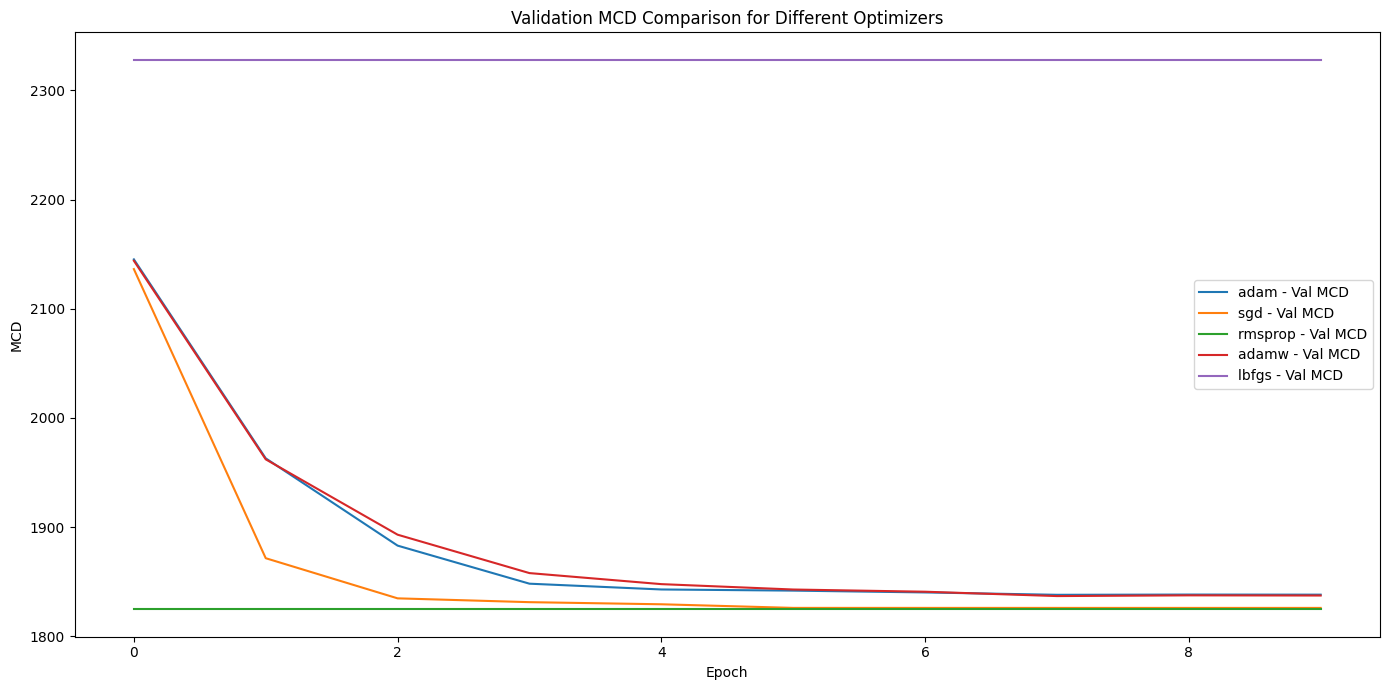

In [60]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def pad_mel_spectrogram(mel_spectrogram, max_length):
    pad_size = max_length - mel_spectrogram.shape[1]
    return torch.nn.functional.pad(mel_spectrogram, (0, pad_size))

class LJSpeechDataset(Dataset):
    def __init__(self, dataset_path="LJSpeech-1.1", num_samples=100):
        metadata_path = os.path.join(dataset_path, "metadata.csv")
        audio_path = os.path.join(dataset_path, "wavs")

        with open(metadata_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        self.samples = []
        self.max_mel_length = 0
        
        for line in lines[:num_samples]:
            parts = line.strip().split("|")
            audio_file = os.path.join(audio_path, parts[0] + ".wav")
            text = parts[1]

            waveform, sr = torchaudio.load(audio_file)
            mel_spectrogram = torchaudio.transforms.MelSpectrogram(n_mels=80)(waveform)
            mel_spectrogram = torch.mean(mel_spectrogram, dim=0)

            mel_spectrogram = mel_spectrogram / (mel_spectrogram.max() + 1e-10)  # Avoid division by zero

            self.max_mel_length = max(self.max_mel_length, mel_spectrogram.shape[1])

            text_embedding = torch.randn(400)

            self.samples.append((text_embedding, mel_spectrogram, mel_spectrogram.shape[1]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text_embedding, mel_spectrogram, mel_length = self.samples[idx]
        mel_spectrogram = pad_mel_spectrogram(mel_spectrogram, self.max_mel_length)
        return text_embedding, mel_spectrogram, mel_length

def masked_mse_loss(pred, target, lengths):
    mask = torch.arange(target.shape[1]).unsqueeze(0) < lengths.unsqueeze(1)
    mask = mask.unsqueeze(-1).to(target.device)
    
    loss = (pred - target) ** 2
    loss = loss * mask
    return loss.sum() / mask.sum()

class Tacotron2Placeholder(nn.Module):
    def __init__(self, input_dim=400, hidden_dim=1024, output_dim=80):
        super(Tacotron2Placeholder, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.output_activation = nn.ReLU()  # Ensure non-negative outputs
        self._initialize_weights()

    def forward(self, x, max_frames):
        hidden = self.relu(self.hidden_layer(x))
        output = self.output_layer(hidden)
        output = self.output_activation(output)  # Apply ReLU activation
        output = output.view(x.size(0), max_frames, -1)
        return output

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def reinitialize_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def get_optimizer(model, optimizer_type='adam', lr=0.0001, momentum=0.9):
    if optimizer_type == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'sgd':
        return optim.SGD(model.parameters(), lr=0.01, momentum=momentum)  # Increased learning rate
    elif optimizer_type == 'lbfgs':
        return optim.LBFGS(model.parameters(), lr=0.0001, history_size=20, max_iter=100)  # Further reduced parameters
    elif optimizer_type == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)  # RMSprop optimizer
    elif optimizer_type == 'adamw':
        return optim.AdamW(model.parameters(), lr=lr)  # AdamW optimizer
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

def check_for_nans(tensor, name=""):
    if torch.isnan(tensor).any():
        raise ValueError(f"NaN values found in {name}")
    if torch.isinf(tensor).any():
        raise ValueError(f"Inf values found in {name}")

def monitor_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"Gradient for {name}: {param.grad.norm()}")

def compute_mcd(pred, target, lengths):
    mask = torch.arange(target.shape[1]).unsqueeze(0) < lengths.unsqueeze(1)
    mask = mask.unsqueeze(-1).to(target.device)
    pred = pred * mask
    target = target * mask

    epsilon = 1e-10
    pred_log = torch.log(pred + epsilon)
    target_log = torch.log(target + epsilon)

    # Check for NaNs/Infs in log transformation
    if torch.isnan(pred_log).any() or torch.isinf(pred_log).any():
        print("NaN or Inf values found in pred_log")
    if torch.isnan(target_log).any() or torch.isinf(target_log).any():
        print("NaN or Inf values found in target_log")

    diff = pred_log - target_log
    squared_diff = diff ** 2
    sum_squared_diff = torch.sum(squared_diff, dim=-1)
    mcd = 10.0 / torch.log(torch.tensor(10.0)) * torch.sqrt(2.0 * sum_squared_diff)
    
    # Check for NaNs/Infs in MCD computation
    if torch.isnan(mcd).any() or torch.isinf(mcd).any():
        print(f"pred_log: {pred_log}")
        print(f"target_log: {target_log}")
        print(f"diff: {diff}")
        print(f"squared_diff: {squared_diff}")
        print(f"sum_squared_diff: {sum_squared_diff}")
        raise ValueError("NaN or Inf values found in MCD computation")

    mcd = torch.sum(mcd * mask.squeeze(-1)) / torch.sum(mask)
    return mcd.item()

def train_one_epoch(epoch, model, criterion, optimizer, dataloader, device, scaler, amp, optimizer_type):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        text_input, mel_target, mel_lengths = batch
        check_for_nans(text_input, "text_input")
        check_for_nans(mel_target, "mel_target")
        check_for_nans(mel_lengths, "mel_lengths")
        text_input, mel_target, mel_lengths = text_input.to(device), mel_target.to(device), mel_lengths.to(device)

        def closure():
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=amp):
                mel_predicted = model(text_input, mel_target.size(1))
                check_for_nans(mel_predicted, "mel_predicted")
                loss = criterion(mel_predicted, mel_target, mel_lengths)
                check_for_nans(loss, "loss")
            loss.backward()
            monitor_gradients(model)  # Monitor gradients
            return loss
        
        if optimizer_type == 'lbfgs':
            loss = optimizer.step(closure)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients
        else:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=amp):
                mel_predicted = model(text_input, mel_target.size(1))
                check_for_nans(mel_predicted, "mel_predicted")
                loss = criterion(mel_predicted, mel_target, mel_lengths)
                check_for_nans(loss, "loss")
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients
            scaler.step(optimizer)
            scaler.update()

        epoch_loss += loss.item()
    
    average_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch + 1}, Optimizer {optimizer_type}, Train Loss: {average_loss}")
    return average_loss

def validate(model, criterion, dataloader, device):
    model.eval()
    val_loss = 0
    val_mcd = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            text_input, mel_target, mel_lengths = batch
            check_for_nans(text_input, "text_input")
            check_for_nans(mel_target, "mel_target")
            check_for_nans(mel_lengths, "mel_lengths")
            text_input, mel_target, mel_lengths = text_input.to(device), mel_target.to(device), mel_lengths.to(device)
            mel_predicted = model(text_input, mel_target.size(1))
            check_for_nans(mel_predicted, "mel_predicted")
            loss = criterion(mel_predicted, mel_target, mel_lengths)
            check_for_nans(loss, "loss")
            val_loss += loss.item()
            
            mcd = compute_mcd(mel_predicted, mel_target, mel_lengths)
            val_mcd += mcd
    average_val_loss = val_loss / len(dataloader)
    average_val_mcd = val_mcd / len(dataloader)
    print(f"Validation Loss: {average_val_loss}, Validation MCD: {average_val_mcd}")
    return average_val_loss, average_val_mcd

dataset_path = "LJSpeech-1.1"
num_samples = 100
batch_size = 16  # Increased batch size
learning_rate = 0.0001
epochs = 10

train_dataset = LJSpeechDataset(dataset_path=dataset_path, num_samples=num_samples)
val_dataset = LJSpeechDataset(dataset_path=dataset_path, num_samples=20)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cpu")
criterion = masked_mse_loss

optimizers = ['adam', 'sgd', 'rmsprop', 'adamw', 'lbfgs']  # Added alternative optimizers
all_losses = {}

for opt in optimizers:
    print(f"Training with {opt} optimizer")
    model = Tacotron2Placeholder().to(device)
    reinitialize_model(model)  # Reinitialize model weights
    optimizer = get_optimizer(model, optimizer_type=opt, lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler(enabled=False)

    train_losses = []
    val_losses = []
    val_mcds = []
    
    for epoch in range(epochs):
        train_loss = train_one_epoch(epoch, model, criterion, optimizer, train_loader, device, scaler, False, opt)
        val_loss, val_mcd = validate(model, criterion, val_loader, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_mcds.append(val_mcd)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MCD: {val_mcd:.4f}")
    
    all_losses[opt] = (train_losses, val_losses, val_mcds)

# Function to plot training and validation statistics
def plot_statistics(all_losses, metric_name='Loss'):
    plt.figure(figsize=(14, 7))
    
    for opt in all_losses:
        train_losses, val_losses, val_mcds = all_losses[opt]
        
        # Plot training loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label=f'{opt} - Train {metric_name}')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.title(f'Training {metric_name} Comparison for Different Optimizers')
        plt.legend()
        
        # Plot validation loss or MCD
        plt.subplot(1, 2, 2)
        plt.plot(val_losses, label=f'{opt} - Val {metric_name}')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.title(f'Validation {metric_name} Comparison for Different Optimizers')
        plt.legend()
        
    plt.tight_layout()
    plt.show()

# Plot training and validation losses
plot_statistics(all_losses, metric_name='Loss')

# Function to plot validation MCD
def plot_mcd(all_losses):
    plt.figure(figsize=(14, 7))
    
    for opt in all_losses:
        _, _, val_mcds = all_losses[opt]
        
        # Plot validation MCD
        plt.plot(val_mcds, label=f'{opt} - Val MCD')
        plt.xlabel('Epoch')
        plt.ylabel('MCD')
        plt.title('Validation MCD Comparison for Different Optimizers')
        plt.legend()
        
    plt.tight_layout()
    plt.show()

# Plot validation MCD
plot_mcd(all_losses)